## TRATAMIENTO DATASET

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14,9]

import collections
from PIL import Image

from fastai import *
from fastai.callbacks import *
from fastai.vision import *
from fastai.metrics import error_rate


import fastai
fastai.__version__

'1.0.54'

In [3]:
path = Path("IMÁGENES FILTRADAS/")

In [4]:
path.ls()

[PosixPath('IMÁGENES FILTRADAS/BURKITT_32.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_20.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_16.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_21.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_110.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_48.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_85.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_73.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_7.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_138.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_44.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_147.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_62.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_135.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LCM_23.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_107.jpg'),
 PosixPath('IMÁGENES FILTRAD

In [5]:
fnames = get_image_files(path)
fnames[:10]

[PosixPath('IMÁGENES FILTRADAS/BURKITT_32.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_20.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_16.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_21.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_110.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_48.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_85.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_73.jpg')]

In [6]:
pat = r'/([^/]+)_\d+.jpg$'

In [7]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=363).normalize(imagenet_stats)

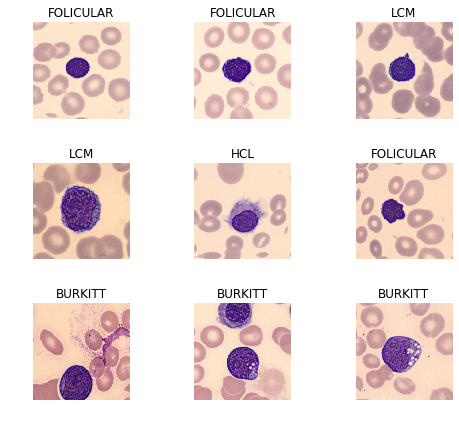

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
train = data.train_ds
valid = data.valid_ds

In [10]:
df= pd.concat([train.to_df(),valid.to_df()], ignore_index=False)
df.head()

,x,y
0,BURKITT_32.jpg,BURKITT
1,LLC_6.jpg,LLC
2,FOLICULAR_20.jpg,FOLICULAR
3,BURKITT_16.jpg,BURKITT
4,HCL_21.jpg,HCL


In [11]:
df.columns=['Image','Id']
df.head()

,Image,Id
0,BURKITT_32.jpg,BURKITT
1,LLC_6.jpg,LLC
2,FOLICULAR_20.jpg,FOLICULAR
3,BURKITT_16.jpg,BURKITT
4,HCL_21.jpg,HCL


In [12]:
print(data.classes)

['BURKITT', 'FOLICULAR', 'HCL', 'LCM', 'LLC']


In [13]:
len(data.classes),data.c

(5, 5)

In [14]:
df['Id'].value_counts()[:5]

BURKITT      188
FOLICULAR    149
LCM           59
LLC           57
HCL           48
Name: Id, dtype: int64

In [15]:
df['target'] = 1
df1 = df.copy()
df['target'] = 0
df = df.append(df1)
target_col = 2

In [16]:
df.head()

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,0
1,LLC_6.jpg,LLC,0
2,FOLICULAR_20.jpg,FOLICULAR,0
3,BURKITT_16.jpg,BURKITT,0
4,HCL_21.jpg,HCL,0


In [17]:
df.shape

(1002, 3)

## ITEMBASE Y ITEMLIST

In [18]:
mean, std = torch.tensor(imagenet_stats)

class SiamImage(ItemBase):
    def __init__(self, img1, img2): 
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [19]:
class SiamImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        match=1
        if i>=len(self.items)//2:
            match = 0
        fn = self.items[i]
        img1 = super().get(i) 

        imgs = self.inner_df.Image.values
        ids = self.inner_df.Id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) 
        return SiamImage(img1, img2)

    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

In [20]:
whl_tfms = get_transforms()
bs = 8

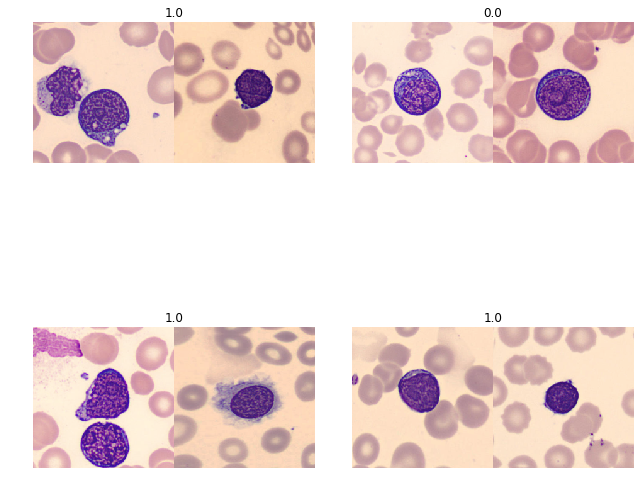

In [21]:
data = (SiamImageItemList.from_df(df=df, path=path, cols=0)
         .split_by_rand_pct(valid_pct=0.2, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

data.show_batch(2)

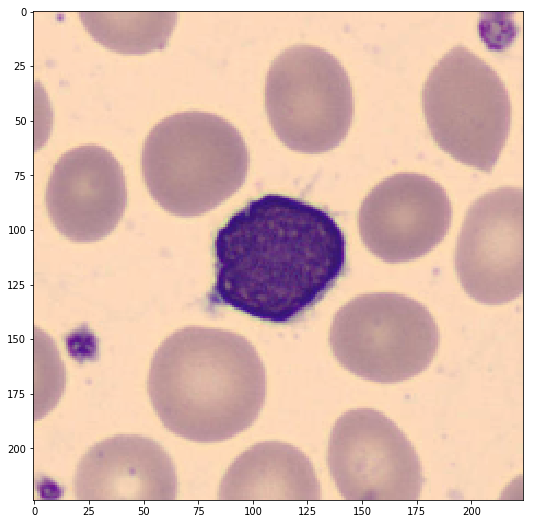

In [22]:
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

## IMPORTAR DICCIONARIOS

In [23]:
import pickle
pickle_in = open("dict.pickle","rb")
pesos_dic50 = pickle.load(pickle_in)

In [24]:
pretrained_dict = pesos_dic50
modelo50 = models.resnet50(pretrained=True)
model_dict = modelo50.state_dict()

In [25]:
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
modelo50.load_state_dict(model_dict)

In [26]:
pesos_dic50

OrderedDict([('0.0.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
                          4.4022e-

## SNN Y LOSS FUNCTION

In [30]:
from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet50, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        model_dict = self.body.state_dict()
        pretrained_dict = pesos_dic50
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict) 
        self.body.load_state_dict(model_dict)
        self.head = learner.create_head(num_features_model(self.body) * 1, self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [31]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

## INSTANCIAR EL MODELO

In [32]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()) ) 

In [33]:
siam_learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,50.477539,11.317726,00:14
1,26.443201,10.414110,00:12


In [34]:
siam_learner.save('stage-1')

In [35]:
siam_learner.load('stage-1')

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ContrastiveLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (802 items)
x: SiamImageItemList
SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: IMÁGENES FILTRADAS;

Valid: LabelList (200 items)
x: SiamImageItemList
SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
0.0,0.0,0.0,1.0,0.0
Path: IMÁGENES FILTRADAS;

Test: None, model=SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), strid

In [36]:
siam_learner.unfreeze()

In [37]:
siam_learner.fit_one_cycle(4, slice(1e-5))

epoch,train_loss,valid_loss,time
0,22.645445,10.571001,00:12
1,22.368364,10.259024,00:12
2,22.605049,10.187833,00:12
3,21.891701,10.266346,00:12


In [38]:
siam_learner.load('stage-1');

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ContrastiveLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [39]:
siam_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


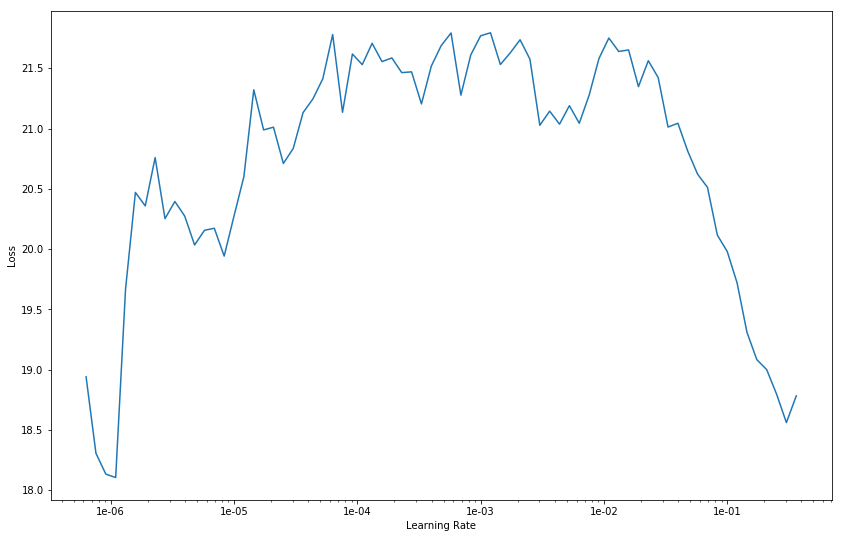

In [40]:
siam_learner.recorder.plot()

In [45]:
siam_learner.unfreeze()

In [41]:
siam_learner.fit_one_cycle(4, slice(9e-5))

epoch,train_loss,valid_loss,time
0,21.605576,10.406405,00:12
1,21.502920,10.342107,00:12
2,20.051065,10.357159,00:12
3,20.775637,10.378439,00:12


In [42]:
siam_learner.model

SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kerne

In [43]:
siam_learner.save('stage-2')

In [44]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds

In [45]:
data = (SiamImageItemList.from_df(df=df, path=path, cols=0)
         .split_by_rand_pct(valid_pct=1, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=4))

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [46]:
dl = data.valid_dl
ds = data.valid_ds
res = extract_embedding(dl, ds, model)

In [47]:
res.numpy().shape

(1002, 128)

In [48]:
whlc= np.array([df.loc[df.Image == Path(i.split(sep='/')[1]), 'Id'].values[0] for i in ds.items])

In [49]:
res.shape

torch.Size([1002, 128])

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [51]:
pca.fit(res)
embs2d = pca.transform(res)

In [52]:
import colorsys
def random_colors(N, bright=True):
    
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_embeddings(embeddings=None,whlc=None, xlim=None, ylim=None):

    plt.figure(figsize=(10,10))
    for cnt, i in enumerate(set(whlc)):

        inds = np.where(whlc==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[cnt])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(set(whlc))

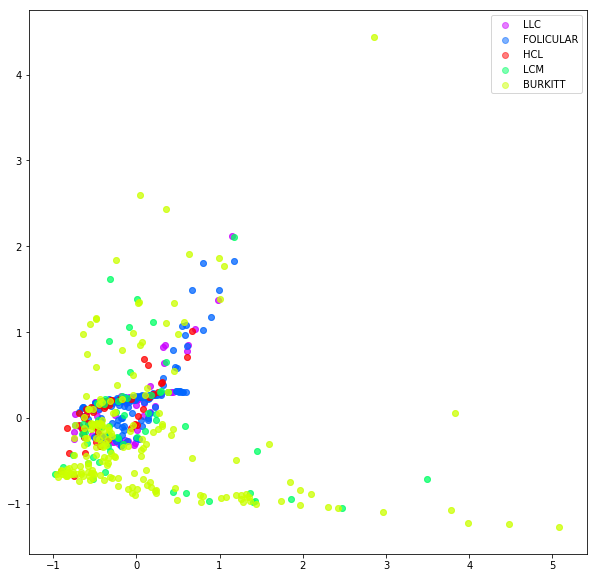

In [53]:
colors = random_colors(len(set(whlc)))
plot_embeddings(embs2d,whlc, xlim=None, ylim=None)

In [54]:
features = pd.DataFrame(res.numpy())
features['label'] = whlc
features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,0.163844,0.083685,-0.031300,0.064002,-0.263091,0.022682,0.075710,-0.182312,-0.099136,0.171707,...,-0.064122,-0.132367,-0.094502,0.042972,0.093654,0.288726,-0.107886,-0.098255,0.370715,LCM
1,0.026423,-0.301006,-0.107249,0.055866,0.236203,0.062035,0.060423,-0.137039,0.053037,-0.142679,...,0.052055,0.057288,0.021528,0.092724,-0.100361,-0.054873,-0.000944,0.100488,-0.201329,BURKITT
2,-0.042191,0.030821,0.057803,-0.026208,0.127861,0.041756,0.008085,0.086914,0.046831,0.018581,...,0.028821,-0.050989,0.067660,0.144266,0.003831,0.011457,-0.017292,0.001818,-0.002371,LLC
3,-0.274370,0.106721,-0.179576,-0.031145,-0.118428,-0.117796,0.098021,0.045153,-0.029328,0.022347,...,-0.016384,-0.007030,0.091819,-0.112265,-0.191749,-0.386690,0.065052,-0.130193,-0.099013,FOLICULAR
4,0.089160,-0.098642,-0.024811,0.062412,0.109472,0.056713,-0.149896,0.033665,-0.073876,-0.049124,...,0.016284,-0.013021,-0.061963,-0.051685,-0.044689,0.022059,-0.002865,0.018793,-0.103444,FOLICULAR


In [55]:
features.shape

(1002, 129)

In [56]:
def oneshot(model,img1,img2):
    output1,output2 = model(img1.cuda(),img2.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    return euclidean_distance

In [57]:
df_original = df1.reset_index(drop=True)
df_original.head()

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,1
1,LLC_6.jpg,LLC,1
2,FOLICULAR_20.jpg,FOLICULAR,1
3,BURKITT_16.jpg,BURKITT,1
4,HCL_21.jpg,HCL,1


In [58]:
df_original

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,1
1,LLC_6.jpg,LLC,1
2,FOLICULAR_20.jpg,FOLICULAR,1
3,BURKITT_16.jpg,BURKITT,1
4,HCL_21.jpg,HCL,1
5,HCL_10.jpg,HCL,1
6,FOLICULAR_85.jpg,FOLICULAR,1
7,BURKITT_73.jpg,BURKITT,1
8,BURKITT_7.jpg,BURKITT,1
9,BURKITT_138.jpg,BURKITT,1


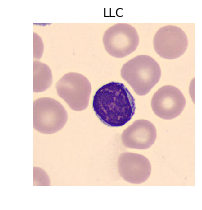

In [148]:
im1 = open_image( path / df_original.Image[485])
im1.show()
plt.title(df_original.Id[485])
plt.show()

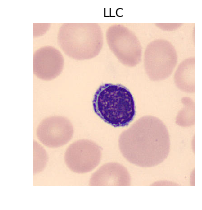

In [151]:
im2 = open_image( path / df_original.Image[1])
im2.show()
plt.title(df_original.Id[1])
plt.show()

In [152]:
oneshot(siam_learner.model, im1.resize(224).data[None,:,:,:], im2.resize(224).data[None,:,:,:])

tensor([0.1006], device='cuda:0', grad_fn=<NormBackward1>)

In [68]:
def obtenervector(im1, im2, mdl):
    mdl.eval()
    with torch.no_grad():
        out1, out2 = mdl(im1,im2)
        return out1, out2

In [69]:
c=0
for cnt, (x, y) in enumerate(dl, start=0):
    c = c+1
    o1,o2 = model(x[0],x[1])
    v = x[0]
    if c == 1:
        break
   

In [70]:
oneshot(siam_learner.model, v[[2]], v[[1]])

tensor([0.6768], device='cuda:0', grad_fn=<NormBackward1>)

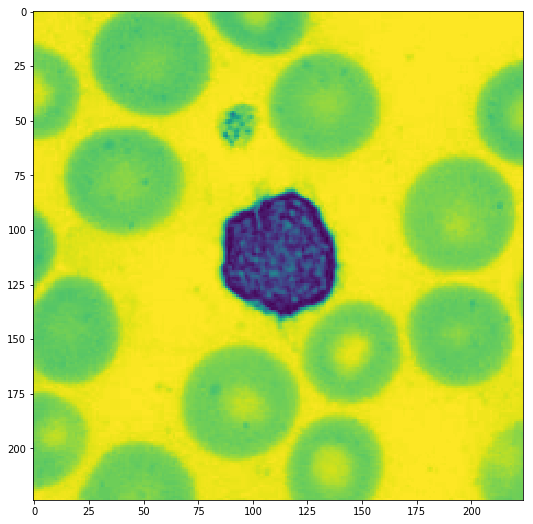

In [71]:
plt.imshow(v.cpu().numpy()[3][0])


In [72]:
oneshot(siam_learner.model, im1.resize(224).data[None,:,:,:], im2.resize(224).data[None,:,:,:])

tensor([0.0013], device='cuda:0', grad_fn=<NormBackward1>)

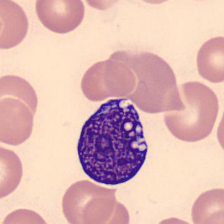

In [73]:
im1.resize(224)